In [106]:
# get_ipython().magic('matplotlib notebook')
# get_ipython().magic('matplotlib inline')
# get_ipython().magic('load_ext autoreload')
# get_ipython().magic('autoreload 2')
%matplotlib inline
%load_ext autoreload
%autoreload 2
    
#___________________________________________________________________________________________________________________
import os
import tripyview as tpv
import shapefile as shp
import numpy     as np
import xarray    as xr
import time      as clock
import matplotlib.pyplot as plt
import warnings
xr.set_options(keep_attrs=True)
do_parallel       = False
parallel_nprc     = 48   # number of dask workers
parallel_nprc_bin = 10   # number of processor used to parallize the binning loop
parallel_tmem     = 200  # max. available RAM

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### INFO:
To compute especially on large unstructured grids #vertices>1M, you need to run this notebook in parallel (do_parallel=True) on several workers (parallel_nprc...is the number of dask worker that can be allocated, parallel_tmem...is the maximum available RAM that will be distributed between the dask workers). Therefor allocate a full !!! COMPUTE NODE !!! (admins might not be happy if you do this in parallel on a login node) of a HPC of your choice with as much memory (RAM) as you can get to run this notebook!

In [107]:
if do_parallel:
    from dask.distributed import Client
    # from dask.diagnostics import ProgressBar
    import dask
    print(' --> memory_limit: {:3.3f} GB'.format(parallel_tmem/(parallel_nprc)))
    ## dask.config.config.get('distributed').get('dashboard').update({'link':'{JUPYTERHUB_SERVICE_PREFIX}/proxy/{port}/status'})
    client = Client(n_workers=parallel_nprc, threads_per_worker=1, memory_limit='{:3.3f} GB'.format(parallel_tmem/parallel_nprc))
    client

In [108]:
# Parameters
mesh_path = '/albedo/work/user/pscholz/mesh_fesom2.0/core2_srt_dep@node/'
# mesh_path = '/albedo/work/user/pscholz/mesh_fesom2.0/dart_test/'
save_path = None #'~/figures/test_papermill/'
save_fname= None

#_____________________________________________________________________________________
input_paths= list()
input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_jayne_bin_ck0.1/5/')
input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_nycander_bin_ck0.1/5/')
input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_stormtide_bin_ck0.1/5/')
input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/5/')
# input_paths.append('/albedo/work/user/pscholz/results/dart_linfs_pc0_ctrl_1/1/')

input_names= list()
input_names.append('TKE+IDEMIX, jayne')
input_names.append('TKE+IDEMIX, nycander')
input_names.append('TKE+IDEMIX, stormtide')
input_names.append('TKE')

# n_cycl: which spinupcycle should be plottet if do_allcycl all spinupcycles from [1...n_cycle] are plottet, if None path is directly used
n_cycl    = None 
vname     = 'ghflx'
year      = [1979,2019]
mon, day, record, box, depth = None, None, None, None, None

#_____________________________________________________________________________________
box_region = list()
box_region.append('global')
box_region.append('moc_basins/Atlantic_MOC.shp')
box_region.append('moc_basins/IndoPacific_MOC.shp')
# box_region.append('ocean_basins/Atlantic_Basin.shp')
# box_region.append('ocean_basins/Pacific_Basin.shp')

#_____________________________________________________________________________________
# do anomaly plots in case ref_path is not None
ref_path  = None #'/home/ollie/pscholz/results/trr181_tke_ctrl_ck0.1/' # None
ref_name  = None # 'TKE, ck=0.1' # None
ref_year  = None # [2009,2019]
ref_mon, ref_day, ref_record = None, None, None

#_____________________________________________________________________________________
cstr, cnum = 'blue2red', 20
cref, crange, cmin, cmax, cfac, climit = None, None, None, None, None, None
chist, ctresh = True, 0.995

# ref_cstr, ref_cnum = 'wbgyr', 15
# ref_cref, ref_crange, ref_cmin, ref_cmax, ref_cfac, ref_climit = None, None, None, None, None, None
# ref_chist, ref_ctresh = True, 0.995

#_____________________________________________________________________________________
ncol, nrow        = 1, 1 #3 , None      # number of pannel columns in figure
plt_opt           = dict({'marker':'o'})
do_allcycl        = True 
do_enum           = False  # do enumeration of panels
do_shdw           = False
do_mean           = True
save_dpi          = 300
save_fmt          = ['png']

In [109]:
#___LOAD FESOM2 MESH___________________________________________________________________________________
mesh=tpv.load_mesh_fesom2(mesh_path, do_rot='None', focus=0, do_info=True, do_pickle=True,
                          do_earea=True, do_narea=True)

#______________________________________________________________________________________________________
if n_cycl is not None:
    cycl_s = n_cycl
    if do_allcycl: cycl_s=1
    aux_path, aux_name = list(), list()
    input_paths_old, input_names_old = input_paths, input_names
    for ii, (ipath,iname) in enumerate(zip(input_paths,input_names)):
        for ii_cycl in range(cycl_s, n_cycl+1):
            aux_path.append(os.path.join(ipath,'{:d}/'.format(ii_cycl)))
            if not do_allcycl: aux_name.append('{}'.format(iname))
            else             : aux_name.append('{:d}) {}'.format(ii_cycl, iname))
            print(ii, aux_path[-1],aux_name[-1])
    input_paths, input_names = aux_path, aux_name

    if (ref_path is not None): 
        aux_path, aux_name = list(), list()
        ref_path_old, ref_name_old = ref_path, ref_name
        for ii_cycl in range(cycl_s, n_cycl+1):
            aux_path.append(os.path.join(ref_path,'{:d}/'.format(ii_cycl)))
            if not do_allcycl: aux_name.append('{}'.format(ref_name))
            else             : aux_name.append('{:d}) {}'.format(ii_cycl, ref_name))
            print('R', ref_path[-1])        
        ref_path, ref_name = aux_path, aux_name
    del(aux_path, aux_name)    
        
#______________________________________________________________________________________________________
cinfo=tpv.set_cinfo(cstr, cnum, crange, cmin, cmax, cref, cfac, climit, chist, ctresh)
ref_cinfo=None
if (ref_path is not None): 
    if ref_year   is None: ref_year   = year
    if ref_mon    is None: ref_mon    = mon
    if ref_record is None: ref_record = record
    cinfo['cref']=0.0 
    ref_cinfo=tpv.set_cinfo(ref_cstr, ref_cnum, ref_crange, ref_cmin, ref_cmax, ref_cref, ref_cfac, ref_climit, ref_chist, ref_ctresh)

#______________________________________________________________________________________________________    
# concatenate list = list1+list2
if (ref_path is not None): 
    if isinstance(ref_path, list): 
        input_paths, input_names = ref_path + input_paths        , ref_name + input_names
    else:    
        input_paths, input_names = list([ref_path]) + input_paths, list([ref_name]) + input_names
        
#______________________________________________________________________________________________________
box = list()
shp_path = os.path.join(tpv.__path__[0],'shapefiles/')
for region in box_region:
    if region == 'global' or isinstance(region,list): box.append(region)
    else: box.append(shp.Reader(os.path.join(shp_path,region)))            

 > found *.pckl file: /albedo/work/user/pscholz/mesh_fesom2.0/core2_srt_dep@node
 > load  *.pckl file: tripyview_fesom2_core2_srt_dep@node_focus0.pckl
___FESOM2 MESH INFO________________________
 > path            = /albedo/work/user/pscholz/mesh_fesom2.0/core2_srt_dep@node
 > id              = core2_srt_dep@node
 > do rot          = None
 > [al,be,ga]      = 50, 15, -90
 > do augmpbnd     = True
 > do cavity       = False
 > do lsmask       = True
 > do earea,eresol = True, False
 > do narea,nresol = True, False
___________________________________________
 > #node           = 126858
 > #elem           = 244659
 > #lvls           = 48
___________________________________________


In [110]:
#___LOAD FESOM2 DATA___________________________________________________________________________________    
data_list = list()
for datapath, descript in zip(input_paths, input_names): 
    print(datapath, descript)
    ts = clock.time()
    #__________________________________________________________________________________________________
    # load data
    data = tpv.load_data_fesom2(mesh, datapath, vname='fh', year=year, descript=descript, do_info=False, 
                                do_load=False, do_persist=True)
    
    #__________________________________________________________________________________________________    
    # check if data where loaded
    if data is None: raise ValueError(f'data == None, data could not be readed, your path:{datapath} might be wrong!!!')
        
    #__________________________________________________________________________________________________
    print(' --> elasped time to load, prepare u,v data: {:3.2f} min.'.format( (clock.time()-ts)/60  ))        
    print(' --> data uses {:3.2f} Gb:'.format(data.nbytes/(1024**3)))
    
    #__________________________________________________________________________________________________
    # compute meridional heat flux from surface heatflux fh by binning
    ts = clock.time()
    data_list.append(tpv.calc_gmhflx_box(mesh, data, box, dlat=1.0, do_info=False, do_parallel=do_parallel, 
                                         n_workers=parallel_nprc_bin))
    print(' --> elasped time to comp. global. merid. Hflux: {:3.2f} min.'.format( (clock.time()-ts)/60  ))   
    del(data)

/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_jayne_bin_ck0.1/5/ TKE+IDEMIX, jayne
 --> elasped time to load, prepare u,v data: 0.02 min.
 --> data uses 0.00 Gb:
 --> elasped time to comp. global. merid. Hflux: 0.01 min.
/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_nycander_bin_ck0.1/5/ TKE+IDEMIX, nycander
 --> elasped time to load, prepare u,v data: 0.04 min.
 --> data uses 0.00 Gb:
 --> elasped time to comp. global. merid. Hflux: 0.01 min.
/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_stormtide_bin_ck0.1/5/ TKE+IDEMIX, stormtide
 --> elasped time to load, prepare u,v data: 0.04 min.
 --> data uses 0.00 Gb:
 --> elasped time to comp. global. merid. Hflux: 0.01 min.
/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/5/ TKE
 --> elasped time to load, prepare u,v data: 0.04 min.
 --> data uses 0.00 Gb:
 --> elasped time to comp. global. merid. Hflux: 0.01 min.


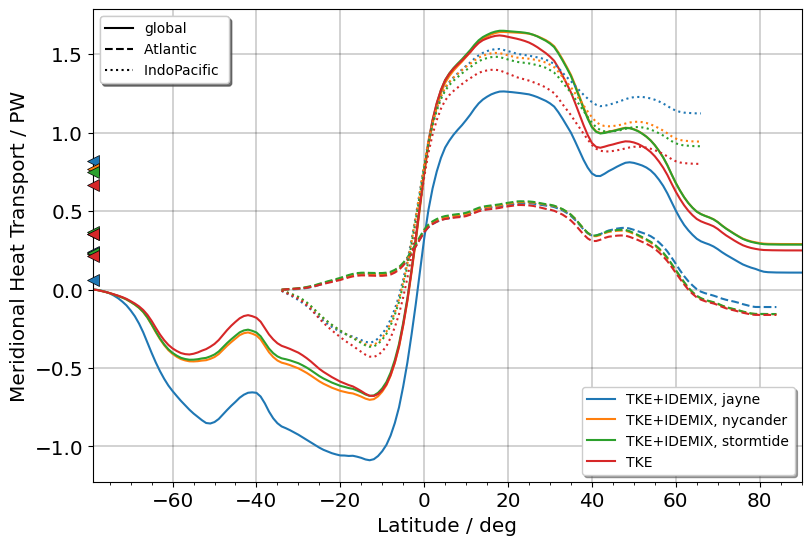

In [112]:
ncol0  = np.min([ncol,len(box)])    
nrow0  = np.ceil(len(box)/ncol0).astype('int')
if nrow != None: nrow0=nrow
svname = list(data_list[0][0].data_vars)[0]
slabel = data_list[0][0][svname].attrs['str_lsave']
sbox   = data_list[0][0][svname].attrs['boxname'].replace(' ','_').lower()

#__________________________________________________________________________________________________
# do save filename path
spath  = save_path
sfpath = None
if spath!=None: 
    sfpath=list()
    for sfmt in save_fmt: sfpath.append( os.path.join(spath,'{:s}_{:s}_{:s}_{:s}.{:s}'.format(svname, 'hline', stname ,slabel, sfmt)) )
#__________________________________________________________________________________________________
hfig, hax = tpv.plot_hline(data_list           , 
                    box        = box           , 
                    box_idx    = None          ,
                    boxl_opt   = dict()        , # option for box label string 
                    nrow       = nrow0         , # number of row in figures panel
                    ncol       = ncol0         ,
                    ax_opt=dict({'fig_sizefac':3,}),
                    do_allcycl = do_allcycl    ,   
                    n_cycl     = n_cycl        ,
                    do_enum    = do_enum       ,
                    do_shdw    = do_shdw       ,
                    do_mean    = do_mean       ,
                    do_save    = sfpath, save_dpi=save_dpi, 
                    )   